# Fugu Example Notebook - Fibonacci Sequence

Brad Aimone, 3/14/2022.  Happy Pi Day.

This notebook shows how Fugu can be used to generate more complex arithmetic circuits from  basic streaming arithmetic functions such as addition.  The goal of this notebook is to show how more complex arithemetic fucntinos can be simply composed from Fugu bricks.


### Neuron Coding Scheme

The examples in this notebook describe circuits that use inputs which are encoded using a little-endian-in-time (LEIT) coding scheme.  LEIT coding is simple - think of a binary description of a number (19 = 10011), flip it around so the least significant bit is first (19 => 11001), and then have the input neuron spike at the first, second, and fifth timesteps. 

## Step 0: Setup
First, we need to import Fugu and other relevant libraries.  Here, we will include the adder bricks

In [1]:
import networkx as nx
import numpy as np
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend
from fugu.bricks import streaming_adder, temporal_shift
%load_ext autoreload
%autoreload 2

## Example 1: Brute force circuit

The goal of this circuit is to implement the Fibonacci sequence by brute force; if we want to go 10 layers, we will have 10 adders.  

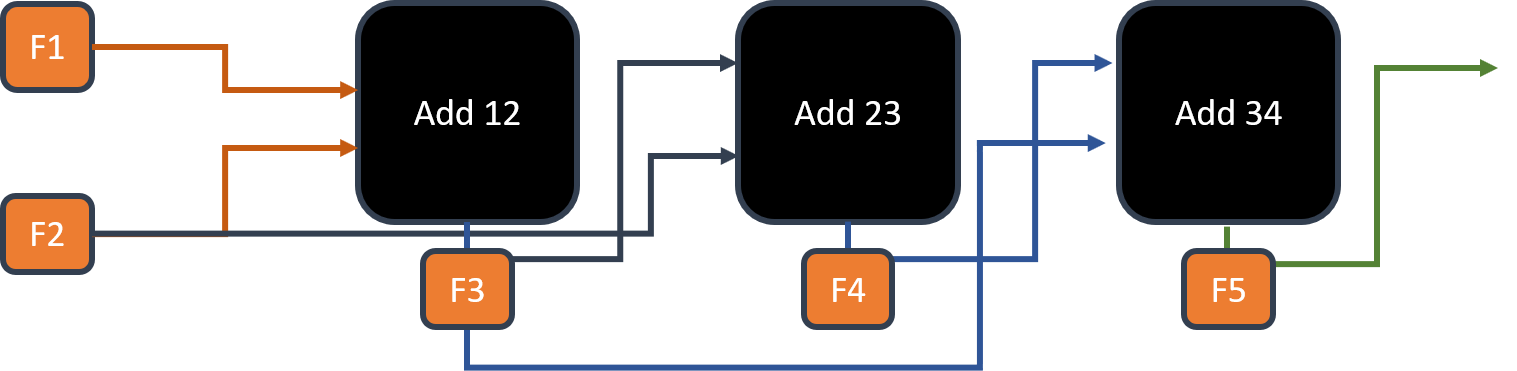

In [2]:
scaffold = Scaffold()

F_1=[0,0]
F_2=[1,0]
shift_length_total = 2

scaffold.add_brick(Vector_Input(np.array([F_1]), coding='binary-L', name='F1', time_dimension=True), 'input') #0
scaffold.add_brick(Vector_Input(np.array([F_2]), coding='binary-L', name='F2', time_dimension=True), 'input') #1

# The first adder will add of F1 and F2.  This output is F3
scaffold.add_brick(streaming_adder(name='add_12_'), [(0,0), (1,0)], output=True) #2

# The second adder adds a time-delayed version (2 timesteps) of F2 and F3.  This output is F4
scaffold.add_brick(temporal_shift(name='shift_2_', shift_length=shift_length_total), [(1,0)], output=True) #3
scaffold.add_brick(streaming_adder(name='add_23_'), [(2,0), (3,0)], output=True)

# The third adder adds a time-delayed version of F3 and F4.  This output is F5
scaffold.add_brick(temporal_shift(name='shift_3_', shift_length=shift_length_total), [(2,0)], output=True) #5
scaffold.add_brick(streaming_adder(name='add_34_'), [(4,0), (5,0)], output=True)

# The fourth adder adds a time-delayed version of F4 and F5.  This output is F6
scaffold.add_brick(temporal_shift(name='shift_4_', shift_length=shift_length_total), [(4,0)], output=True) #7
scaffold.add_brick(streaming_adder(name='add_45_'), [(6,0), (7,0)], output=True)

# and so forth.  We'll do this for 10 elements
scaffold.add_brick(temporal_shift(name='shift_5_', shift_length=shift_length_total), [(6,0)], output=True) #9
scaffold.add_brick(streaming_adder(name='add_56_'), [(8,0), (9,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_6_', shift_length=shift_length_total), [(8,0)], output=True) #11
scaffold.add_brick(streaming_adder(name='add_67_'), [(10,0), (11,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_7_', shift_length=shift_length_total), [(10,0)], output=True) #13
scaffold.add_brick(streaming_adder(name='add_78_'), [(12,0), (13,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_8_', shift_length=shift_length_total), [(12,0)], output=True) #15
scaffold.add_brick(streaming_adder(name='add_89_'), [(14,0), (15,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_9_', shift_length=shift_length_total), [(14,0)], output=True) #17
scaffold.add_brick(streaming_adder(name='add_910_'), [(16,0), (17,0)], output=True) 

scaffold.lay_bricks()

In [3]:
backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(50)
print(result)

     time  neuron_number
0     0.0            5.0
1     0.0            0.0
2     0.0            3.0
3     1.0            1.0
4     1.0            4.0
5     1.0            8.0
6     1.0           12.0
7     2.0           11.0
8     2.0           14.0
9     2.0            6.0
10    3.0           13.0
11    3.0           17.0
12    3.0           18.0
13    3.0           21.0
14    4.0           23.0
15    4.0            7.0
16    4.0           15.0
17    4.0           17.0
18    5.0           20.0
19    5.0           26.0
20    5.0           30.0
21    6.0           29.0
22    6.0           22.0
23    6.0           24.0
24    6.0           26.0
25    7.0           29.0
26    7.0           32.0
27    7.0           16.0
28    7.0           35.0
29    7.0           39.0
..    ...            ...
83   17.0           62.0
84   17.0           71.0
85   17.0           72.0
86   17.0           80.0
87   18.0           65.0
88   18.0           77.0
89   18.0           83.0
90   18.0           58.0


In [4]:
import matplotlib.pyplot as plot
num_elements=scaffold.graph.number_of_nodes()
print('Number of neurons: ', num_elements)
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plot.show()

Number of neurons:  84


<Figure size 640x480 with 1 Axes>

This figure is not all that useful, aside from showing that the calculation completed and moved from the beginning of the circuit towards the end of the circuit as time passed.  

Instead, we want to know what the final number is in the sequence (or, presumably, all of the numbers in the sequence)

In [5]:

for i in range(0,8):
    add_element=12+9*i
    #print(result.loc[result.neuron_number==add_element-6])
    #print(result.loc[result.neuron_number==add_element-5])
    #print(result.loc[result.neuron_number==add_element-1]) # num_elements for the last one

    last_adder_begin=np.sum(result.query('neuron_number=='+str(add_element)+'-6')['time'])
    #print(last_adder_begin)
    query_str=str(last_adder_begin)+' <= time and neuron_number ==' +str(add_element-1)
    #print(query_str)
    f10=np.sum(2**(result.query(query_str)['time']-last_adder_begin))
    print('Fibonacci ' + str(i+3) + ' '+ str(f10) +' at neuron ' + str(add_element-1))
    #f10 = np.sum(2**(result.query(query_str)['time'] – last_adder_begin))
    #Fibo1=result.to_numpy()
    #int_Fibo1=Fibo1.astype(int)

Fibonacci 3 1.0 at neuron 11
Fibonacci 4 2.0 at neuron 20
Fibonacci 5 3.0 at neuron 29
Fibonacci 6 5.0 at neuron 38
Fibonacci 7 8.0 at neuron 47
Fibonacci 8 13.0 at neuron 56
Fibonacci 9 21.0 at neuron 65
Fibonacci 10 34.0 at neuron 74


## Example 2: Recursion

So wait - you may be asking "Isn't the value of the Fibonacci sequence recursion?".  Indeed, in a conventional programming paradigm, we would just put the add inside a loop like this:

Loop from 1 to N

    F_n2=F_n0+F_n1
    
    F_n0=F_n1
    
    F_n1=F_n2
    
End Loop

This is more than just a convenience.  In the example above, we are using 9 neurons per Fibonaccin number.  So if we wanted the next 100 numbers, we have to use 900 neurons.  Can we do this more efficiently?

Loops are of course possible in neurons as well.  Neural networks have recurrent neural networks (like LSTMs and reservoir networks).  For spiking networks we similarly can just engineer a loop into our circuit while accounting for delays in a circuit like this.  

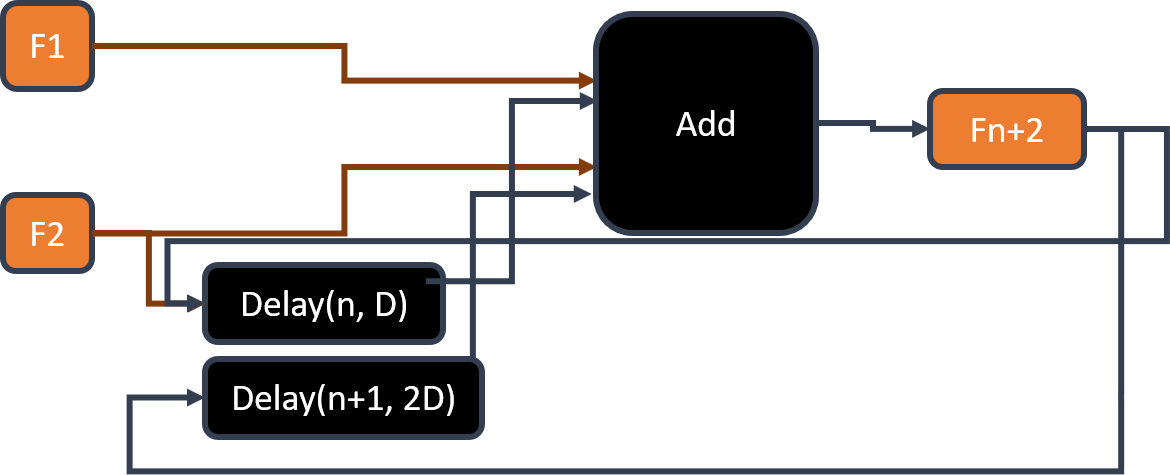



This is recursion is a problem though.  **Scaffolds are described as directed acyclic graphs**, but the circuit in the image above is cyclic.  

Here, we will take the brick definitino of *streaming_adder* and update it to include the recursive pieces.

To do this, we have to consider that our adder will overflow at a certain level of precision.  So we need to run the brick with a hard coded set of delays that are analogous to the precision of the numbers that the Fibonacci sequence will generate.


    

In [49]:
class fibonacci_adder(Brick):
    
    """
    streaming adder function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None, precision=16):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']
        
    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build streaming adder brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 2:
            raise ValueError("adder takes in 2 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        new_begin_node_name = self.name + '_begin'
        
        graph.add_node(new_begin_node_name, index = -2, threshold = 0.0, decay =0.0, p=1.0, potential=0.0)
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = .9,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)
        
        # As a recursive circuit, complete does not really make sense here...
        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=0.5, delay=3+precision)
        graph.add_edge(control_nodes[1]['complete'], new_complete_node_name, weight=0.5, delay=3)

        graph.add_edge(control_nodes[0]['begin'], new_begin_node_name, weight=1.0, delay=2)

        complete_node = new_complete_node_name
        begin_node = new_begin_node_name
        
     
        l = len(input_lists[0])
        
        # Adder nodes
        
        #nodes
        graph.add_node(self.name + 'add', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry0', threshold=1.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry1', threshold=2.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry1', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'carry0', self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'add', self.name + 'out', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'out', weight=-1.0, delay=1)
        graph.add_edge(self.name + 'carry1', self.name + 'out', weight=1.0, delay=1)
        
        # Delay edges -- here, we need one explicit delay node
        # and then we need to repeat the outputs to different nodes with the correct delays        
        graph.add_node(self.name+'relay1',threshold=.9, decay=1.0, p=1.0, potential=0.0)
        
        # First, we will add input F_1 to the relay adder with a delay of *precision*
        
        graph.add_edge(input_lists[1][0], self.name + 'relay1', weight=1.0, delay=precision)
        
        # Second, we will add the output to the same relay with a delay of 2 precisions
        graph.add_edge(self.name + 'out', self.name + 'relay1', weight=1.0, delay=2*precision-2)
        
        # This relay then is input to the adder
        
        graph.add_edge(self.name+'relay1', self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(self.name+'relay1', self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(self.name+'relay1', self.name + 'carry1', weight=1.0, delay=1)
        
        # Finally, we will add the output of the addition of F_n and F_n+1 to the adder with 
        # a corrected delay of *precision-1* (to account for the depth of the adder circuit)
        
        graph.add_edge(self.name + 'out', self.name + 'add', weight=1.0, delay=precision-1)
        graph.add_edge(self.name + 'out', self.name + 'carry0', weight=1.0, delay=precision-1)
        graph.add_edge(self.name + 'out', self.name + 'carry1', weight=1.0, delay=precision-1)
        

        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node, 'begin': begin_node}], output_lists, output_codings)
    

### Recursive Fibonacci use

Now that we have the Fibonacci brick, we can run it for a few timesteps and see what we get.  

      time  neuron_number
0      0.0            5.0
1      0.0            0.0
2      0.0            3.0
3      1.0            1.0
4      1.0            4.0
5      1.0            8.0
6      2.0           11.0
7      2.0            6.0
8      8.0           12.0
9      9.0            8.0
10     9.0            9.0
11    10.0            8.0
12    11.0           11.0
13    12.0            7.0
14    16.0           12.0
15    17.0            8.0
16    18.0           11.0
17    18.0            8.0
18    19.0           11.0
19    25.0            8.0
20    25.0           12.0
21    26.0           11.0
22    26.0            8.0
23    26.0            9.0
24    27.0            8.0
25    28.0           11.0
26    32.0           12.0
27    33.0            8.0
28    33.0            9.0
29    33.0           12.0
..     ...            ...
283  154.0            8.0
284  154.0            9.0
285  154.0           12.0
286  155.0            8.0
287  155.0            9.0
288  155.0           10.0
289  155.0  

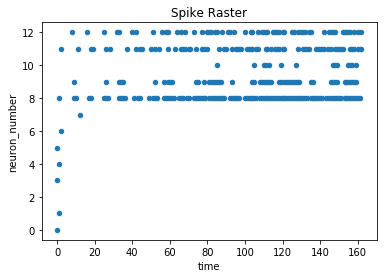

In [50]:
scaffold = Scaffold()

F_1=[0,0]
F_2=[1,0]
precision = 8
num_Fibo=20

scaffold.add_brick(Vector_Input(np.array([F_1]), coding='binary-L', name='F1', time_dimension=True), 'input') #0
scaffold.add_brick(Vector_Input(np.array([F_2]), coding='binary-L', name='F2', time_dimension=True), 'input') #1

scaffold.add_brick(fibonacci_adder(name='Fibo_add', precision=precision), [(0,0), (1,0)], output=True) #2

scaffold.lay_bricks()

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(num_Fibo*precision+3)
print(result)

import matplotlib.pyplot as plot
num_elements=scaffold.graph.number_of_nodes()
print('Number of neurons: ', num_elements)
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plot.show()

As with above, we will read out what is now the single output node every for a binary code every 8 timesteps 

In [52]:
for i in range(0,num_Fibo):
    query_str=str(2+precision*i)+' <= time <'+str(2+precision*(i+1)-1)+'and neuron_number ==' +str(num_elements-2)
    f10=np.sum(2**(result.query(query_str)['time']-precision*i-2))
    print('Fibonacci ' + str(i+3) + ' '+ str(f10))

Fibonacci 3 1.0
Fibonacci 4 2.0
Fibonacci 5 3.0
Fibonacci 6 5.0
Fibonacci 7 8.0
Fibonacci 8 13.0
Fibonacci 9 21.0
Fibonacci 10 34.0
Fibonacci 11 55.0
Fibonacci 12 89.0
Fibonacci 13 16.0
Fibonacci 14 105.0
Fibonacci 15 121.0
Fibonacci 16 99.0
Fibonacci 17 93.0
Fibonacci 18 64.0
Fibonacci 19 30.0
Fibonacci 20 95.0
Fibonacci 21 125.0
Fibonacci 22 92.0


Here, we can see that the first 12 numbers are right, but then we get an overflow.  This is because 55+89 > 128, which is 2^7.  It appears that we are starting to get some overflow errors due to the limited precision of the delays.  We will now repeat the same simulation, but with a higher precision.  
    

      time  neuron_number
0      0.0            5.0
1      0.0            0.0
2      0.0            3.0
3      1.0            1.0
4      1.0            4.0
5      1.0            8.0
6      2.0           11.0
7      2.0            6.0
8     16.0           12.0
9     17.0            8.0
10    17.0            9.0
11    18.0            8.0
12    19.0           11.0
13    20.0            7.0
14    32.0           12.0
15    33.0            8.0
16    34.0           11.0
17    34.0            8.0
18    35.0           11.0
19    49.0            8.0
20    49.0           12.0
21    50.0           11.0
22    50.0            8.0
23    50.0            9.0
24    51.0            8.0
25    52.0           11.0
26    64.0           12.0
27    65.0            8.0
28    65.0            9.0
29    65.0           12.0
..     ...            ...
328  307.0            8.0
329  307.0            9.0
330  308.0            8.0
331  308.0            9.0
332  308.0           12.0
333  309.0            8.0
334  309.0  

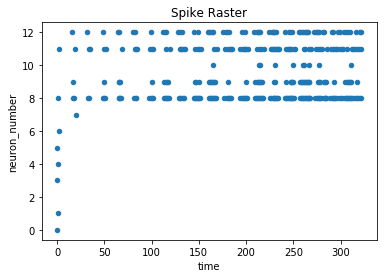

Fibonacci 3 1.0
Fibonacci 4 2.0
Fibonacci 5 3.0
Fibonacci 6 5.0
Fibonacci 7 8.0
Fibonacci 8 13.0
Fibonacci 9 21.0
Fibonacci 10 34.0
Fibonacci 11 55.0
Fibonacci 12 89.0
Fibonacci 13 144.0
Fibonacci 14 233.0
Fibonacci 15 377.0
Fibonacci 16 610.0
Fibonacci 17 987.0
Fibonacci 18 1597.0
Fibonacci 19 2584.0
Fibonacci 20 4181.0
Fibonacci 21 6765.0
Fibonacci 22 10946.0


In [53]:
scaffold = Scaffold()

F_1=[0,0]
F_2=[1,0]
precision = 16
num_Fibo=20

scaffold.add_brick(Vector_Input(np.array([F_1]), coding='binary-L', name='F1', time_dimension=True), 'input') #0
scaffold.add_brick(Vector_Input(np.array([F_2]), coding='binary-L', name='F2', time_dimension=True), 'input') #1

scaffold.add_brick(fibonacci_adder(name='Fibo_add', precision=precision), [(0,0), (1,0)], output=True) #2

scaffold.lay_bricks()

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(num_Fibo*precision+3)
print(result)

import matplotlib.pyplot as plot
num_elements=scaffold.graph.number_of_nodes()
print('Number of neurons: ', num_elements)
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plot.show()
for i in range(0,num_Fibo):
    query_str=str(2+precision*i)+' <= time <'+str(2+precision*(i+1)-1)+'and neuron_number ==' +str(num_elements-2)
    f10=np.sum(2**(result.query(query_str)['time']-precision*i-2))
    print('Fibonacci ' + str(i+3) + ' '+ str(f10))

This is promising.  By having each cycle take 16 timesteps instead of 8, we can represent 15 bit numbers.  Importantly **the number of neurons is the same regardless of precision**.  Rather, all we are paying is time.  What about spikes?  We can see below that increasing the precision to 24 while looking at the same number of Fibonacci numbers does not change the number of spikes.  Both simulations require 357 spikes and 13 neurons.  

      time  neuron_number
0      0.0            5.0
1      0.0            0.0
2      0.0            3.0
3      1.0            1.0
4      1.0            4.0
5      1.0            8.0
6      2.0           11.0
7      2.0            6.0
8     24.0           12.0
9     25.0            8.0
10    25.0            9.0
11    26.0            8.0
12    27.0           11.0
13    28.0            7.0
14    48.0           12.0
15    49.0            8.0
16    50.0           11.0
17    50.0            8.0
18    51.0           11.0
19    73.0            8.0
20    73.0           12.0
21    74.0           11.0
22    74.0            8.0
23    74.0            9.0
24    75.0            8.0
25    76.0           11.0
26    96.0           12.0
27    97.0            8.0
28    97.0            9.0
29    97.0           12.0
..     ...            ...
328  459.0            8.0
329  459.0            9.0
330  460.0            8.0
331  460.0            9.0
332  460.0           12.0
333  461.0            8.0
334  461.0  

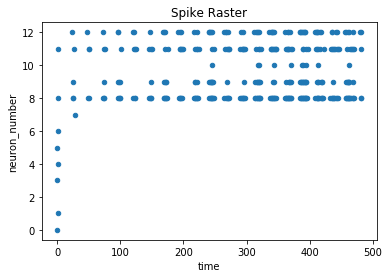

Fibonacci 3 1.0
Fibonacci 4 2.0
Fibonacci 5 3.0
Fibonacci 6 5.0
Fibonacci 7 8.0
Fibonacci 8 13.0
Fibonacci 9 21.0
Fibonacci 10 34.0
Fibonacci 11 55.0
Fibonacci 12 89.0
Fibonacci 13 144.0
Fibonacci 14 233.0
Fibonacci 15 377.0
Fibonacci 16 610.0
Fibonacci 17 987.0
Fibonacci 18 1597.0
Fibonacci 19 2584.0
Fibonacci 20 4181.0
Fibonacci 21 6765.0
Fibonacci 22 10946.0


In [54]:
scaffold = Scaffold()

F_1=[0,0]
F_2=[1,0]
precision = 24
num_Fibo=20

scaffold.add_brick(Vector_Input(np.array([F_1]), coding='binary-L', name='F1', time_dimension=True), 'input') #0
scaffold.add_brick(Vector_Input(np.array([F_2]), coding='binary-L', name='F2', time_dimension=True), 'input') #1

scaffold.add_brick(fibonacci_adder(name='Fibo_add', precision=precision), [(0,0), (1,0)], output=True) #2

scaffold.lay_bricks()

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(num_Fibo*precision+3)
print(result)

import matplotlib.pyplot as plot
num_elements=scaffold.graph.number_of_nodes()
print('Number of neurons: ', num_elements)
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plot.show()
for i in range(0,num_Fibo):
    query_str=str(2+precision*i)+' <= time <'+str(2+precision*(i+1)-1)+'and neuron_number ==' +str(num_elements-2)
    f10=np.sum(2**(result.query(query_str)['time']-precision*i-2))
    print('Fibonacci ' + str(i+3) + ' '+ str(f10))

### Crazy big example

So how far can this go?  Well, in simulation we can actually represent whatever length number we want, so long as we are willing to wait that long.  Of course, in hardware we will be limited by the delays of the hardware platform, but presumably we can break the long delays into a sequence of neurons and edges with smaller delays.  

Just for fun, we'll finish this example with a Fibonacci sequence of 200 numbers.  

          time  neuron_number
0          0.0            5.0
1          0.0            0.0
2          0.0            3.0
3          1.0            1.0
4          1.0            4.0
5          1.0            8.0
6          2.0           11.0
7          2.0            6.0
8        148.0           12.0
9        149.0            8.0
10       149.0            9.0
11       150.0            8.0
12       151.0           11.0
13       152.0            7.0
14       296.0           12.0
15       297.0            8.0
16       298.0           11.0
17       298.0            8.0
18       299.0           11.0
19       445.0            8.0
20       445.0           12.0
21       446.0           11.0
22       446.0            8.0
23       446.0            9.0
24       447.0            8.0
25       448.0           11.0
26       592.0           12.0
27       593.0            8.0
28       593.0            9.0
29       593.0           12.0
...        ...            ...
34301  29584.0           12.0
34302  295

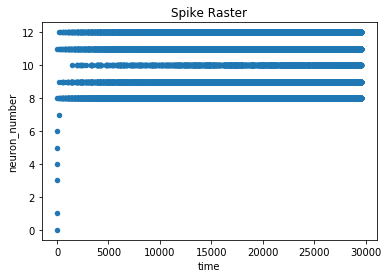

Fibonacci 3 1.0
Fibonacci 4 2.0
Fibonacci 5 3.0
Fibonacci 6 5.0
Fibonacci 7 8.0
Fibonacci 8 13.0
Fibonacci 9 21.0
Fibonacci 10 34.0
Fibonacci 11 55.0
Fibonacci 12 89.0
Fibonacci 13 144.0
Fibonacci 14 233.0
Fibonacci 15 377.0
Fibonacci 16 610.0
Fibonacci 17 987.0
Fibonacci 18 1597.0
Fibonacci 19 2584.0
Fibonacci 20 4181.0
Fibonacci 21 6765.0
Fibonacci 22 10946.0
Fibonacci 23 17711.0
Fibonacci 24 28657.0
Fibonacci 25 46368.0
Fibonacci 26 75025.0
Fibonacci 27 121393.0
Fibonacci 28 196418.0
Fibonacci 29 317811.0
Fibonacci 30 514229.0
Fibonacci 31 832040.0
Fibonacci 32 1346269.0
Fibonacci 33 2178309.0
Fibonacci 34 3524578.0
Fibonacci 35 5702887.0
Fibonacci 36 9227465.0
Fibonacci 37 14930352.0
Fibonacci 38 24157817.0
Fibonacci 39 39088169.0
Fibonacci 40 63245986.0
Fibonacci 41 102334155.0
Fibonacci 42 165580141.0
Fibonacci 43 267914296.0
Fibonacci 44 433494437.0
Fibonacci 45 701408733.0
Fibonacci 46 1134903170.0
Fibonacci 47 1836311903.0
Fibonacci 48 2971215073.0
Fibonacci 49 4807526976.0
Fi

In [56]:
scaffold = Scaffold()

F_1=[0,0]
F_2=[1,0]
precision = 148
num_Fibo=200

scaffold.add_brick(Vector_Input(np.array([F_1]), coding='binary-L', name='F1', time_dimension=True), 'input') #0
scaffold.add_brick(Vector_Input(np.array([F_2]), coding='binary-L', name='F2', time_dimension=True), 'input') #1

scaffold.add_brick(fibonacci_adder(name='Fibo_add', precision=precision), [(0,0), (1,0)], output=True) #2

scaffold.lay_bricks()

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(num_Fibo*precision+3)
print(result)

import matplotlib.pyplot as plot
num_elements=scaffold.graph.number_of_nodes()
print('Number of neurons: ', num_elements)
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plot.show()
for i in range(0,num_Fibo):
    query_str=str(2+precision*i)+' <= time <'+str(2+precision*(i+1)-1)+'and neuron_number ==' +str(num_elements-2)
    f10=np.sum(2**(result.query(query_str)['time']-precision*i-2))
    print('Fibonacci ' + str(i+3) + ' '+ str(f10))